In [3]:
using OrdinaryDiffEq, MLToolkit.Plots

In [4]:
abstract type AbstractObject end

struct Particle{R<:Real, V<:AbstractVector{R}} <: AbstractObject
    mass::R
    position::V
    velocity::V
end

massof(p::Particle) = p.mass
positionof(p::Particle) = p.position
velocityof(p::Particle) = p.velocity

###

abstract type AbstractForce end

struct Force{V<:AbstractVector{<:Real}} <: AbstractForce
    F::V
end

forceof(f::Force) = f.F

###

abstract type AbstractEnvironment end

struct Earth{F<:AbstractForce} <: AbstractEnvironment
    force::F
end

getforce(earth::Earth, p::Particle) = forceof(earth.force) + massof(p) * [0.0, -9.8]

getforce (generic function with 1 method)

In [5]:
function step(obj::T, env; dt=0.1) where {T<:Particle}
    # d position d t = velocity
    dpdt(pos, vel, p, t) = vel
    # d velocity d t = acceleration
    dvdt(pos, vel, p, t) = getforce(env, obj) / massof(obj)

    problem = DynamicalODEProblem(dpdt, dvdt, positionof(obj), velocityof(obj), (0.0, 1.0))
    integrator = init(problem, VerletLeapfrog(); dt=dt)
    step!(integrator, dt)
    
    return T(massof(obj), integrator.u.x[1], integrator.u.x[2])
end

function steps(obj::T, env, n_steps; dt=0.1) where {T<:Particle}
    path = Vector{T}(undef, n_steps)
    for i in 1:n_steps
        path[i] = step(obj, env; dt=dt)
        obj = path[i]
    end
    return path
end

obj = Particle(1.0, [0.0, 0.0], [10.0, 20.0])
env = Earth(Force([0.0, -10.0]))

traj = steps(obj, env, 10)

;

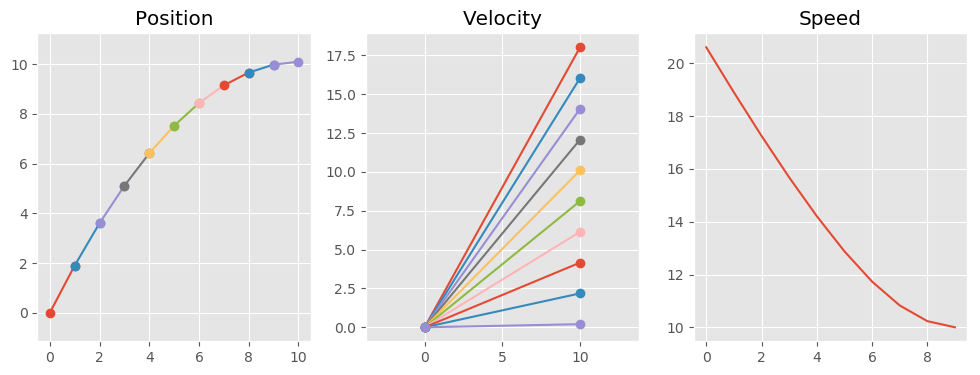

In [6]:
function plot(obj, env)
    traj = steps(obj, env, 10)

    pos = hcat(positionof.(traj)...)
    vel = hcat(velocityof.(traj)...)

    ncols = 3
    fig, axes = plt.subplots(nrows=1, ncols=ncols, figsize=(ncols * 4, 4))
    let ax = axes[1]
        for i in 1:size(pos, 2)
            if i == 1
                ax.plot([0, pos[1,i]], [0, pos[2,i]], "-o")
            else
                ax.plot([pos[1,i-1], pos[1,i]], [pos[2,i-1], pos[2,i]], "-o")
            end
        end
        ax.set_title("Position")
        ax.axis("equal")
    end
    let ax = axes[2]
        for i in 1:size(vel, 2)
            ax.plot([0, vel[1,i]], [0, vel[2,i]], "-o")
        end
        ax.set_title("Velocity")
        ax.axis("equal")
    end

    let ax = axes[3]
        spd = sqrt.(dropdims(sum(vel.^2; dims=1); dims=1))
        ax.plot(spd)
        ax.set_title("Speed")
    end
    
    return fig
end

plot_data() = plot(obj, env)

plot_data() |> display

;

In [7]:
using Turing

In [8]:
@model single_force(pos_list, vel_list) = begin
    F ~ MvNormal(zeros(2), 10 * ones(2))
    
    obj = Particle(1.0, [0.0, 0.0], [10.0, 20.0])
    env = Earth(Force(F))
    
    for i in 1:length(pos_list)
        obj′ = step(obj, env; dt=0.1)
        pos_list[i] ~ MvNormal(positionof(obj′), 0.1)
        vel_list[i] = vel_list[i]
        obj = obj′
    end
end
chain = sample(single_force(positionof.(traj), velocityof.(traj)), PG(100), 500)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:58


Object of type Chains, with data of type 500×5×1 Array{Float64,3}

Log evidence      = 21.954263892136794
Iterations        = 1:500
Thinning interval = 1
Chains            = 1
Samples per chain = 500
internals         = le, lp, weight
parameters        = F[1], F[2]

2-element Array{ChainDataFrame,1}

Summary Statistics
. Omitted printing of 1 columns
│ Row │ parameters │ mean      │ std      │ naive_se  │ mcse      │ ess     │
│     │ Symbol     │ Float64   │ Float64  │ Float64   │ Float64   │ Any     │
├─────┼────────────┼───────────┼──────────┼───────────┼───────────┼─────────┤
│ 1   │ F[1]       │ 0.0696387 │ 0.687506 │ 0.0307462 │ 0.0305337 │ 6.58279 │
│ 2   │ F[2]       │ -9.96507  │ 0.827302 │ 0.036998  │ 0.0895348 │ 6.67011 │

Quantiles
. Omitted printing of 1 columns
│ Row │ parameters │ 2.5%        │ 25.0%     │ 50.0%     │ 75.0%     │
│     │ Symbol     │ Float64     │ Float64   │ Float64   │ Float64   │
├─────┼────────────┼─────────────┼───────────┼───────────┼───────────┤
│

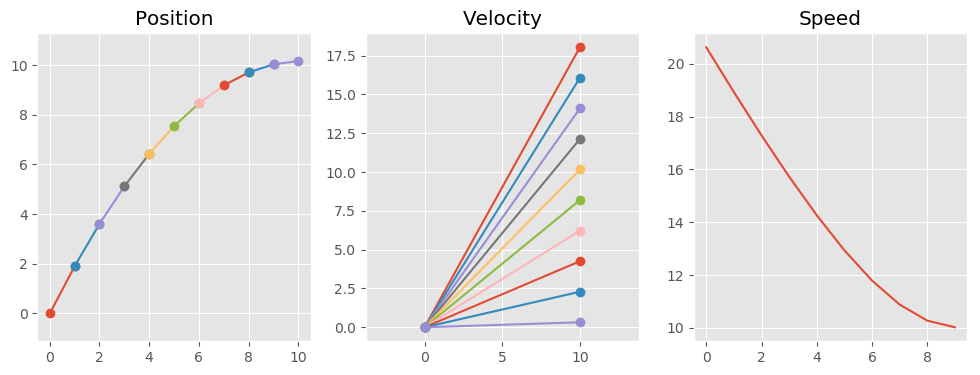

---Inference---


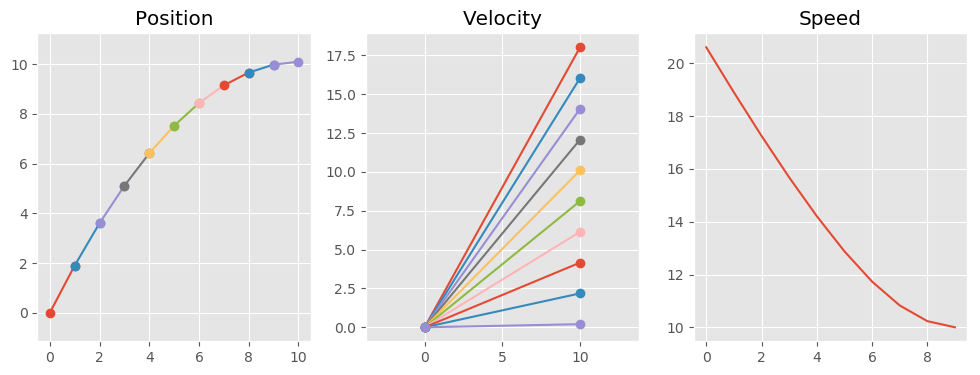

---Data---


In [9]:
res = get(chain[401:500], [:F])
plot(Particle(1.0, [0.0, 0.0], [10.0, 20.0]), Earth(Force([mean.(res.F)...]))) |> display
println("---Inference---")

plot_data() |> display
println("---Data---")